In [1]:
import pandas as pd
import os
import os.path as op
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from dtw import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from scipy.stats import binned_statistic, pearsonr, linregress
from tqdm.notebook import trange, tqdm
from scipy.ndimage import gaussian_filter1d
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.io import read_epochs_eeglab

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
pipeline='NEARICA_behav'
ages=['9m','12m','adult']
condition_epochs={
    'exe': ['LEXT','FTGE','EXGC','EXEND'],
    'obs': ['LOBS','FTGO','OBGC','OBEND']
}

epoch_time_limits={
    'LEXT': [-1500,1000],
    'FTGE': [-500,1000],
    'EXGC': [-1000,1500],
    'EXEND': [-1500,1500],
    'LOBS': [-1500,1000],
    'FTGO': [-500,1000],
    'OBGC': [-1000,1500],
    'OBEND': [-1500,1500],
}

def load_bursts(pipeline, age):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_bursts.mat')
        if os.path.exists(fname):
            with h5py.File(fname, 'r') as f:
                bursts['age'].extend([age for x in list(f['bursts']['trial'])])
                bursts['subject'].extend([subject for x in list(f['bursts']['trial'])])
                bursts['chan'].extend(list(np.squeeze(f['bursts']['chan'][:])))
                bursts['cluster'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['cluster'][:])])
                bursts['epoch'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['epoch'][:])])
                bursts['fwhm_freq'].extend(list(np.squeeze(f['bursts']['fwhm_freq'][:])))
                bursts['fwhm_time'].extend(list(np.squeeze(f['bursts']['fwhm_time'][:])))
                bursts['peak_adjustment'].extend(list(np.squeeze(f['bursts']['peak_adjustment'][:])))
                bursts['peak_amp_base'].extend(list(np.squeeze(f['bursts']['peak_amp_base'][:])))
                bursts['peak_amp_iter'].extend(list(np.squeeze(f['bursts']['peak_amp_iter'][:])))
                bursts['peak_freq'].extend(list(np.squeeze(f['bursts']['peak_freq'][:])))
                bursts['peak_time'].extend(list(np.squeeze(f['bursts']['peak_time'][:])))
                bursts['polarity'].extend(list(np.squeeze(f['bursts']['polarity'][:])))
                bursts['trial'].extend(list(np.squeeze(f['bursts']['trial'][:])))
                for i in range(f['bursts']['waveform'][:,:].shape[1]):
                    bursts['waveform'].append(f['bursts']['waveform'][:,i])
                bursts['waveform_times']=f['bursts']['waveform_times'][:]
                
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    bursts['waveform']=np.array(bursts['waveform'])
    bursts['waveform_times']=np.array(bursts['waveform_times'])
    
    return bursts

In [3]:
def combine_bursts(bursts_9m, bursts_12m, bursts_adult):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    for age, age_bursts in zip(['9m','12m','adult'], [bursts_9m, bursts_12m, bursts_adult]):
        bursts['age'].extend([age for x in list(age_bursts['trial'])])
        bursts['subject'].extend(['{}_{}'.format(x,age) for x in list(age_bursts['subject'])])
        bursts['chan'].extend([x for x in list(age_bursts['chan'])])
        bursts['cluster'].extend([x for x in list(age_bursts['cluster'])])
        bursts['epoch'].extend([x for x in list(age_bursts['epoch'])])
        bursts['fwhm_freq'].extend([x for x in list(age_bursts['fwhm_freq'])])
        bursts['fwhm_time'].extend([x for x in list(age_bursts['fwhm_time'])])
        bursts['peak_adjustment'].extend([x for x in list(age_bursts['peak_adjustment'])])
        bursts['peak_amp_base'].extend([x for x in list(age_bursts['peak_amp_base'])])
        bursts['peak_amp_iter'].extend([x for x in list(age_bursts['peak_amp_iter'])])
        bursts['peak_freq'].extend([x for x in list(age_bursts['peak_freq'])])
        bursts['peak_time'].extend([x for x in list(age_bursts['peak_time'])])
        bursts['polarity'].extend([x for x in list(age_bursts['polarity'])])
        bursts['trial'].extend([x for x in list(age_bursts['trial'])])
    
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    
    return bursts

In [4]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = len(np.where(results > threshold)[0])
    return PCS_to_analyse


In [5]:
c_bursts_9m=load_bursts(pipeline, '9m')

loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044


In [6]:
c_bursts_12m=load_bursts(pipeline, '12m')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033


In [7]:
c_bursts_adult=load_bursts(pipeline, 'adult')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022


In [8]:
all_bursts=combine_bursts(c_bursts_9m, c_bursts_12m, c_bursts_adult)

In [9]:
c_burst_times_9m=c_bursts_9m['waveform_times']
c_burst_times_12m=c_bursts_12m['waveform_times']
c_burst_times_adult=c_bursts_adult['waveform_times']
med_c_9m=np.percentile(c_bursts_9m['waveform'], 50, axis=0)
med_c_12m=np.percentile(c_bursts_12m['waveform'], 50, axis=0)
med_c_adult=np.percentile(c_bursts_adult['waveform'], 50, axis=0)
norm_c_adult=med_c_adult/np.max(med_c_adult)
norm_c_12m=med_c_12m/np.max(med_c_12m)
norm_c_9m=med_c_9m/np.max(med_c_9m)
alignment_c_9m=dtw(norm_c_9m, norm_c_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_c_9m_idx=warp(alignment_c_9m,index_reference=False)
alignment_c_12m=dtw(norm_c_12m, norm_c_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_c_12m_idx=warp(alignment_c_12m,index_reference=False)
aligned_c_9m_bursts=c_bursts_9m['waveform'][:,aligned_c_9m_idx]
aligned_c_12m_bursts=c_bursts_12m['waveform'][:,aligned_c_12m_idx]
aligned_c_adult_bursts=c_bursts_adult['waveform'][:,:-1]

In [10]:
burst_std_c_9m=RobustScaler().fit_transform(c_bursts_9m['waveform'])
burst_std_warped_9m=RobustScaler().fit_transform(aligned_c_9m_bursts)

burst_std_c_12m=RobustScaler().fit_transform(c_bursts_12m['waveform'])
burst_std_warped_12m=RobustScaler().fit_transform(aligned_c_12m_bursts)

In [11]:
pca_9m = PCA(n_components=20)
pca_9m=pca_9m.fit(burst_std_c_9m)
pcs_9m = pca_9m.transform(burst_std_c_9m)

pca_warped_9m = PCA(n_components=20)
pca_warped_9m=pca_warped_9m.fit(burst_std_warped_9m)
pcs_warped_9m = pca_warped_9m.transform(burst_std_warped_9m)

pca_12m = PCA(n_components=20)
pca_12m=pca_12m.fit(burst_std_c_12m)
pcs_12m = pca_12m.transform(burst_std_c_12m)

pca_warped_12m = PCA(n_components=20)
pca_warped_12m=pca_warped_12m.fit(burst_std_warped_12m)
pcs_warped_12m = pca_warped_12m.transform(burst_std_warped_12m)

In [12]:
def shuffle_array(array):
    X_array = array.copy()
    rows, columns = array.shape
    for col in range(columns):
        ixes = np.arange(0,rows)
        np.random.shuffle(ixes)
        X_array[:,col] = X_array[:,col][ixes]
    return X_array

def shuffle_array_range(array, ranges):
    X_array = []
    for x1, x2 in ranges:
        X = wvf[:,x1:x2]
        np.random.shuffle(X)
        X_array.append(X)
    return np.hstack(X_array)

def get_num_components(waveforms, n_comps):
    # robust scaling
    waveforms_scaled = RobustScaler().fit_transform(waveforms)

    # main PCA fitting
    pca_full = PCA(n_components=n_comps)
    pcs_full = pca_full.fit_transform(waveforms_scaled)
    var_full = pca_full.explained_variance_ratio_ 

    # robustness of pca components
    no_of_iter = 100
    pca_vars = []
    for i in range(no_of_iter):
        shuffled_wvf = shuffle_array(waveforms_scaled)

        pca_shuff = PCA(n_components=n_comps)
        pca_shuff.fit(shuffled_wvf)
        pca_vars.append(pca_shuff.explained_variance_ratio_)        
    del shuffled_wvf
    pca_vars=np.array(pca_vars)

    # getting the magic number
    results = np.sum(var_full>pca_vars, axis=0) / no_of_iter
    threshold=1-(.05/n_comps)
    PCS_to_analyse = len(np.where(results > threshold)[0])
    return PCS_to_analyse

In [13]:
cum_var_exp=np.cumsum(pca_9m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

pcs_to_analyze_c_9m=get_num_components(burst_std_c_9m, idx+1)
print('C: {}'.format(pcs_to_analyze_c_9m))

6 components explain 81.604425589367% of variance
C: 6


In [14]:
cum_var_exp=np.cumsum(pca_warped_9m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

pcs_to_analyze_warped_9m=get_num_components(burst_std_warped_9m, idx+1)
print('C: {}'.format(pcs_to_analyze_warped_9m))

6 components explain 81.9080017578807% of variance
C: 6


In [15]:
cum_var_exp=np.cumsum(pca_12m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

pcs_to_analyze_c_12m=get_num_components(burst_std_c_12m, idx+1)
print('C: {}'.format(pcs_to_analyze_c_12m))

6 components explain 83.36774464564571% of variance
C: 6


In [16]:
cum_var_exp=np.cumsum(pca_warped_12m.explained_variance_ratio_)
if len(np.where(cum_var_exp>=.8)[0]):
    idx=np.min(np.where(cum_var_exp>=.8)[0])
else:
    idx=len(cum_var_exp)-1
print('{} components explain {}% of variance'.format(idx+1,cum_var_exp[idx]*100))

pcs_to_analyze_warped_12m=get_num_components(burst_std_warped_12m, idx+1)
print('C: {}'.format(pcs_to_analyze_warped_12m))

5 components explain 80.62117529730737% of variance
C: 5


In [17]:
pcs_to_analyze_c=10

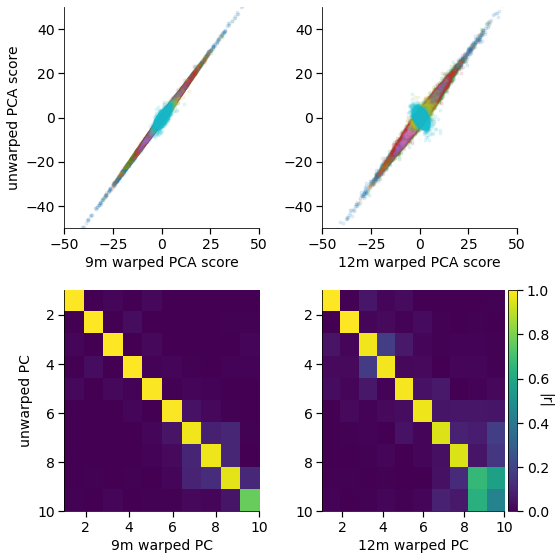

In [18]:
corrmat_9m=np.zeros((pcs_to_analyze_c,pcs_to_analyze_c))
corrmat_12m=np.zeros((pcs_to_analyze_c,pcs_to_analyze_c))
for i in range(pcs_to_analyze_c):
    for j in range(pcs_to_analyze_c):
        res=pearsonr(pcs_warped_9m[:,i],pcs_9m[:,j])
        corrmat_9m[i,j]=np.abs(res[0])
        res=pearsonr(pcs_warped_12m[:,i],pcs_12m[:,j])
        corrmat_12m[i,j]=np.abs(res[0])

plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
fig=plt.figure(figsize=(8,8))

ax=plt.subplot(2,2,1)
plt.plot(pcs_warped_9m[:,0:pcs_to_analyze_c],pcs_9m[:,0:pcs_to_analyze_c],'.',alpha=.1,rasterized=True)
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.xlabel('9m warped PCA score')
plt.ylabel('unwarped PCA score')

plt.subplot(2,2,2)
for i in range(pcs_to_analyze_c):
    plt.plot(pcs_warped_12m[:,i],pcs_12m[:,i],'.',alpha=.1,rasterized=True,label='PC{}'.format(i+1))
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.xlabel('12m warped PCA score')

ax=plt.subplot(2,2,3)
i1=ax.imshow(corrmat_9m, aspect='auto', origin='upper',
             extent=[1, pcs_to_analyze_c, pcs_to_analyze_c, 1])
i1.set_clim([0,1])
ax.set_xticks([2,4,6,8,10])
ax.set_yticks([2,4,6,8,10])
ax.set_xlabel('9m warped PC')
ax.set_ylabel('unwarped PC')

ax=plt.subplot(2,2,4)
i1=ax.imshow(corrmat_12m, aspect='auto', origin='upper',
             extent=[1, pcs_to_analyze_c, pcs_to_analyze_c, 1])
i1.set_clim([0,1])
ax.set_xticks([2,4,6,8,10])
ax.set_yticks([2,4,6,8,10])
ax.set_xlabel('12m warped PC')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb=plt.colorbar(i1, cax=cax)
cb.set_label('|r|', rotation=270)

plt.tight_layout()

plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure8.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure8.png')

In [19]:
print(np.max(corrmat_9m,axis=0))
print(np.max(corrmat_12m,axis=0))

[0.99918562 0.99890919 0.99853881 0.99748764 0.99582133 0.99277267
 0.97823556 0.97403757 0.95861044 0.76619006]
[0.99677885 0.99803971 0.97801082 0.98101018 0.98772222 0.97560172
 0.94700943 0.94673779 0.66538818 0.56680474]
